# Imports

In [51]:
import torch
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tqdm.notebook import tqdm

----------

# Lendo Dataset

In [17]:
# Define pipeline de transformações que serão aplicadas nas imagens de treino
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # redimensiona a imagem para 224x224
    transforms.RandomRotation(30), # rotaciona a imagem em até 30 graus
    transforms.RandomHorizontalFlip(), # flipa a imagem horizontalmente
    transforms.ToTensor(), # coloca a imagem no formato de tensor
    transforms.Normalize( # Normaliza cada canal da imagem com o valor médio e desvio padrão do conjunto de treino do pré-treinamento.
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225] 
    )
])

# Define pipeline de transformações que serão aplicadas nas imagens de validação/inferência
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # redimensiona a imagem para 224x224
    transforms.ToTensor(), # coloca a imagem no formato de tensor
    transforms.Normalize( # Normaliza cada canal da imagem com o valor médio e desvio padrão do conjunto de treino do pré-treinamento.
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])  

# Caminho para o dataset
data_dir = '../data/indoorCVPR_09/Images'

# Cria os datasets de treino e validação com as transformações definidas
train_dataset= datasets.ImageFolder(data_dir, transform=train_transform)
validation_dataset= datasets.ImageFolder(data_dir, transform=data_transform)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))

In [18]:
print('Tamanho completo do dataset: ', dataset_size)

Tamanho completo do dataset:  15620


In [36]:
validation_dataset.classes

['airport_inside',
 'artstudio',
 'auditorium',
 'bakery',
 'bar',
 'bathroom',
 'bedroom',
 'bookstore',
 'bowling',
 'buffet',
 'casino',
 'children_room',
 'church_inside',
 'classroom',
 'cloister',
 'closet',
 'clothingstore',
 'computerroom',
 'concert_hall',
 'corridor',
 'deli',
 'dentaloffice',
 'dining_room',
 'elevator',
 'fastfood_restaurant',
 'florist',
 'gameroom',
 'garage',
 'greenhouse',
 'grocerystore',
 'gym',
 'hairsalon',
 'hospitalroom',
 'inside_bus',
 'inside_subway',
 'jewelleryshop',
 'kindergarden',
 'kitchen',
 'laboratorywet',
 'laundromat',
 'library',
 'livingroom',
 'lobby',
 'locker_room',
 'mall',
 'meeting_room',
 'movietheater',
 'museum',
 'nursery',
 'office',
 'operating_room',
 'pantry',
 'poolinside',
 'prisoncell',
 'restaurant',
 'restaurant_kitchen',
 'shoeshop',
 'stairscase',
 'studiomusic',
 'subway',
 'toystore',
 'trainstation',
 'tv_studio',
 'videostore',
 'waitingroom',
 'warehouse',
 'winecellar']

In [35]:
validation_dataset.class_to_idx

{'airport_inside': 0,
 'artstudio': 1,
 'auditorium': 2,
 'bakery': 3,
 'bar': 4,
 'bathroom': 5,
 'bedroom': 6,
 'bookstore': 7,
 'bowling': 8,
 'buffet': 9,
 'casino': 10,
 'children_room': 11,
 'church_inside': 12,
 'classroom': 13,
 'cloister': 14,
 'closet': 15,
 'clothingstore': 16,
 'computerroom': 17,
 'concert_hall': 18,
 'corridor': 19,
 'deli': 20,
 'dentaloffice': 21,
 'dining_room': 22,
 'elevator': 23,
 'fastfood_restaurant': 24,
 'florist': 25,
 'gameroom': 26,
 'garage': 27,
 'greenhouse': 28,
 'grocerystore': 29,
 'gym': 30,
 'hairsalon': 31,
 'hospitalroom': 32,
 'inside_bus': 33,
 'inside_subway': 34,
 'jewelleryshop': 35,
 'kindergarden': 36,
 'kitchen': 37,
 'laboratorywet': 38,
 'laundromat': 39,
 'library': 40,
 'livingroom': 41,
 'lobby': 42,
 'locker_room': 43,
 'mall': 44,
 'meeting_room': 45,
 'movietheater': 46,
 'museum': 47,
 'nursery': 48,
 'office': 49,
 'operating_room': 50,
 'pantry': 51,
 'poolinside': 52,
 'prisoncell': 53,
 'restaurant': 54,
 'resta

-----------------

# Divisão do Dataset

Divisão das imagens que vão ser utilizadas no conjunto de treino e validação e definição do Dataloader a ser utilizado no treinamento

In [19]:
train_idx, validation_idx = train_test_split(indices, test_size=0.25, random_state=42)
print(len(train_idx), len(validation_idx))

# Define tamanho do batch a ser utilizado
batch_size = 64

# Cria os samplers para o treino e validação que serão passados para o dataloader
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# define dataloader para o conjunto de treino e validação
train_dataloader =  torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler
)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=batch_size,
    sampler=validation_sampler
)


11715 3905


## Distribuição de classes no split de treino e teste

In [44]:
n_classes = 67
def plot_class_distribuition(dataloader):
    labels = torch.zeros(n_classes)
    
    # percorre o dataloader e incrementa o contador de cada classe
    for _, label in dataloader:
        unique_labels, counts = label.unique(return_counts=True)
        labels[unique_labels.long()] += counts
    
    sns.set({'figure.figsize': (10, 12)})
    sns.barplot(x=labels.numpy(), y=dataloader.dataset.classes)

* Treino

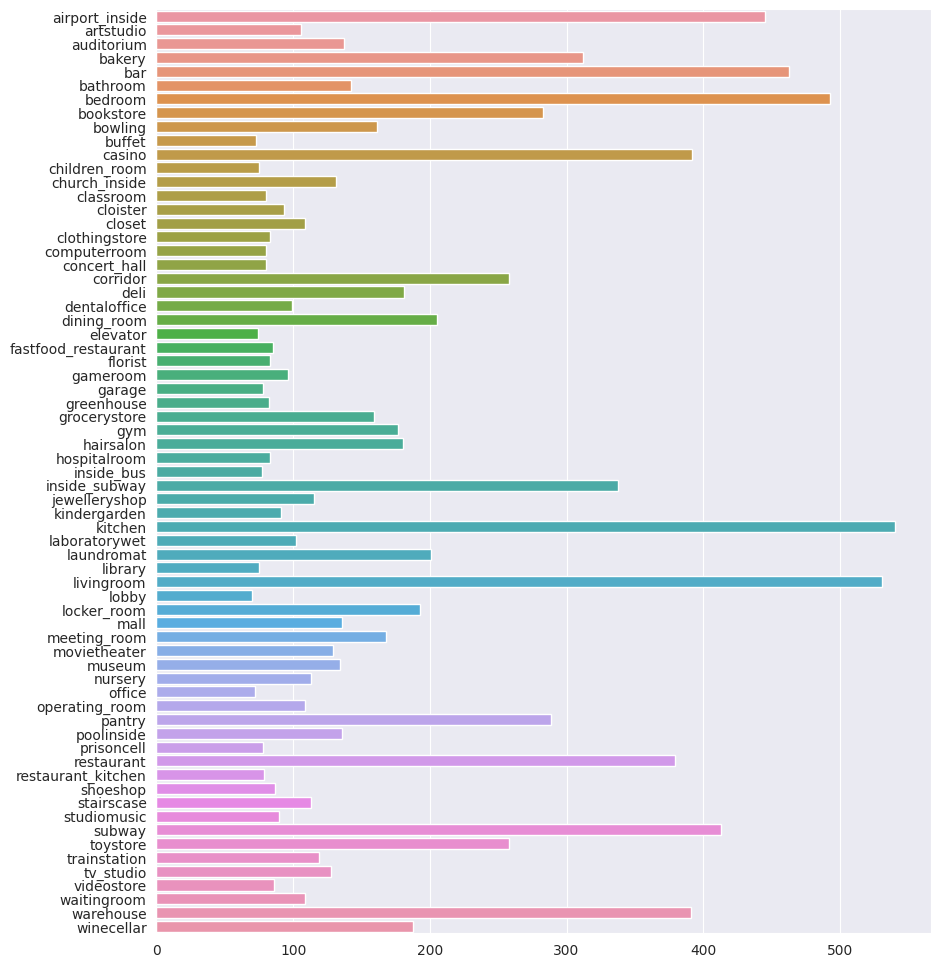

In [46]:
plot_class_distribuition(train_dataloader)

* Validação

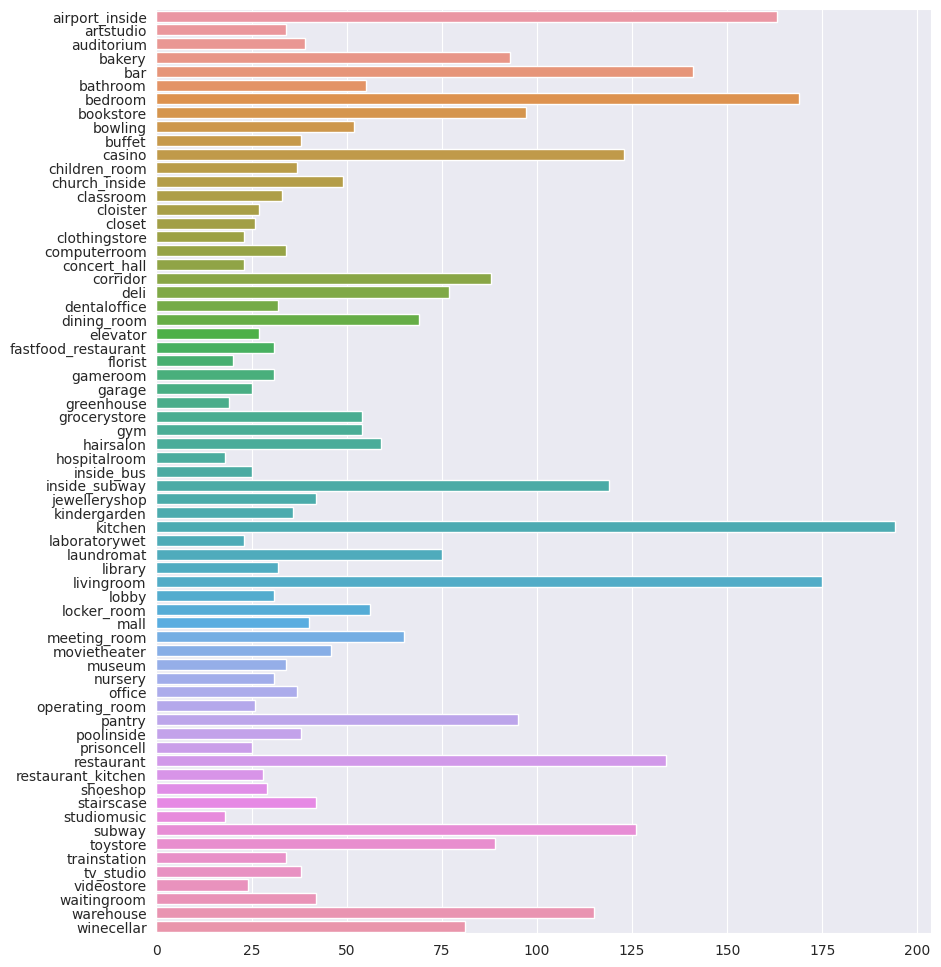

In [45]:
plot_class_distribuition(validation_dataloader)

------

# Lendo Modelo Pré-treinado

In [48]:
# Será utilizado o modelo ResNet
model = timm.create_model('resnet34', pretrained=True, num_classes=n_classes)
x     = torch.randn(1, 3, 224, 224)
model(x).shape

torch.Size([1, 67])

In [49]:
model(x)

tensor([[ 0.0149,  0.3281,  0.0940, -0.0313, -0.0380,  0.2506, -0.0845, -0.0344,
         -0.0040, -0.1276,  0.1130, -0.0706,  0.0078, -0.0340, -0.0125,  0.1388,
          0.0925,  0.0286, -0.0111,  0.0258, -0.0106,  0.1919, -0.0315,  0.0070,
         -0.0848,  0.0764, -0.1658,  0.1560, -0.1263, -0.1357, -0.1526, -0.1410,
         -0.1465,  0.0634,  0.1541, -0.0445, -0.0411,  0.0555,  0.0231, -0.0172,
         -0.0251,  0.0872,  0.0386, -0.0278, -0.0925, -0.1681, -0.1159,  0.0972,
         -0.0931,  0.1019, -0.0458,  0.0030,  0.1948,  0.1900,  0.0536, -0.1798,
          0.0521, -0.0223,  0.0005,  0.1353,  0.0704,  0.1119,  0.0519, -0.1244,
          0.0191,  0.0800, -0.0289]], grad_fn=<AddmmBackward0>)

In [50]:
model.pretrained_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet34_a1_0-46f8f793.pth',
 'hf_hub_id': 'timm/resnet34.a1_in1k',
 'architecture': 'resnet34',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

-----------

# Finetuning Modelo

## Função de Avaliação do Modelo

In [54]:
def evaluate(dataloader, model):
    model.cuda() # Coloca o modelo na gpu
    model.eval() # Coloca o modelo no modo de avaliaçã (inferência)
    
    targets = []
    all_preds = [] 
    
    for x, y in tqdm(dataloader):
        logits = model(x.cuda())
        pred = logits.argmax(1).flatten().cpu().tolist() # pega a classe com maior probabilidade como predito, segundo o modelo
        
        targets.extend(y.cpu().tolist()) # guarda os targets
        all_preds.extend(pred) # guarda os preds
        
    acc = accuracy_score(y_true=targets, y_pred=all_preds) # calcula a acurácia
    cm = confusion_matrix(y_true=targets, y_pred=all_preds) # calcula a matriz de confusão
    f1 = f1_score(y_true=targets, y_pred=all_preds, average='weighted') # calcula o f1 score
    
    return acc, cm, f1

# Apenas testando a implementação
evaluate(validation_dataloader, model)

  0%|          | 0/62 [00:00<?, ?it/s]

(0.006658130601792573,
 array([[0, 3, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 3, 0, ..., 0, 1, 0],
        [0, 0, 5, ..., 0, 0, 0],
        [0, 2, 7, ..., 0, 0, 0]]),
 0.0027825130477594647)

## Definição da época de treinamento

In [57]:
def epoch(dataloader, model, criterion, optimizer):
    model.cuda() # Coloca o modelo na gpu
    model.train() # Coloca o modelo no modo de treino
    
    epoch_loss = 0.
    num_batches = 0
    
    targets = []
    all_preds = [] 

    for x, y in tqdm(dataloader):
        optimizer.zero_grad() # zera o gradiente para garantir que não vai ter 'lixo' armazenado do batch anterior.
        logits = model(x.cuda())
        loss = criterion(input=logits, target=y.cuda())
        
        # Backpropagation: calcula o gradiente da loss em relação aos parâmetros do modelo
        loss.backward()
        
        # Otimização: dado os gradientes calculados, atualiza os parâmetros do modelo, dando um step.
        optimizer.step()
        
        epoch_loss += loss.detach().cpu().item()
        num_batches += 1
        
        # Salva os targets e preds para calcular a acurácia
        pred = logits.argmax(1).flatten().cpu().tolist() 
        all_preds.extend(pred)
        targets.extend(y.cpu().tolist())
    
    acc = accuracy_score(y_true=targets, y_pred=all_preds)
    return epoch_loss / num_batches, acc

## Definição dos parâmetros

In [59]:
summary = {
    'model_state':None,
    'valid_f1_history':[],
    'valid_acc_history':[],
    'valid_cm_history':[],
    'train_loss_history':[],
    'train_acc_history':[],
}

lr = 1e-3
num_epochs = 10
best_acc = 0.0

# define o otimizador adam e passa os parâmetros do modelo a serem otimizados.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define a loss function  
criterion = torch.nn.CrossEntropyLoss(weight=None)

# Treinamento

In [60]:
for e in range(num_epochs):
    print('Epoch:', e)
    # Executa uma época de treinamento
    cur_loss, cur_acc = epoch(train_dataloader, model, criterion, optimizer)
    
    # Avalia performance do modelo na validação
    valid_acc, valid_cm, valid_f1 = evaluate(validation_dataloader, model)
    
    # Métricas no Treino
    summary['train_loss_history'].append(cur_loss)
    summary['train_acc_history'].append(cur_acc)
    
    # Métricas na validação
    summary['valid_acc_history'].append(valid_acc)  
    summary['valid_cm_history'].append(valid_cm)
    summary['valid_f1_history'].append(valid_f1)    
    
    # Salva no summary o modelo com melhor acurácia na validação
    if valid_acc > best_acc:
        best_acc = valid_acc
        summary['model_state'] = model.state_dict()
        print('Best model updated')

    # Printa as métricas
    print('\t Train Loss: {:.4f} | Train Acc: {:.4f} | Valid Acc: {:.4f} | Valid F1: {:.4f}'.format(cur_loss, cur_acc, valid_acc, valid_f1))
    print('\t Valid CM: \n', valid_cm)
    print()
    
summary_path = 'summary.pth'

torch.save(summary, summary_path)

Epoch: 0


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Best model updated
	 Train Loss: 1.1875 | Train Acc: 0.6642 | Valid Acc: 0.6883 | Valid F1: 0.6810
	 Valid CM: 
 [[123   0   0 ...   0   2   0]
 [  0  15   0 ...   0   1   0]
 [  1   0  29 ...   0   0   0]
 ...
 [  1   0   0 ...  20   0   0]
 [  8   0   0 ...   0  81   0]
 [  0   0   4 ...   0   0  60]]

Epoch: 1


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Best model updated
	 Train Loss: 0.8550 | Train Acc: 0.7528 | Valid Acc: 0.7060 | Valid F1: 0.7039
	 Valid CM: 
 [[119   0   1 ...   0   1   0]
 [  0  15   0 ...   0   0   0]
 [  0   0  25 ...   0   0   0]
 ...
 [  1   0   0 ...  21   0   0]
 [  8   0   0 ...   0  80   3]
 [  0   0   1 ...   0   1  62]]

Epoch: 2


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Best model updated
	 Train Loss: 0.6512 | Train Acc: 0.8074 | Valid Acc: 0.7268 | Valid F1: 0.7228
	 Valid CM: 
 [[115   0   3 ...   0   3   0]
 [  0  13   0 ...   1   0   0]
 [  0   0  24 ...   0   0   0]
 ...
 [  1   0   0 ...  22   0   0]
 [  6   0   0 ...   0  80   2]
 [  1   0   2 ...   0   0  65]]

Epoch: 3


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Best model updated
	 Train Loss: 0.5040 | Train Acc: 0.8444 | Valid Acc: 0.7434 | Valid F1: 0.7413
	 Valid CM: 
 [[117   0   1 ...   1   2   0]
 [  0  17   0 ...   0   0   0]
 [  1   0  19 ...   1   0   0]
 ...
 [  0   1   0 ...  25   0   0]
 [  1   0   0 ...   0  91   2]
 [  1   0   1 ...   0   2  62]]

Epoch: 4


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

	 Train Loss: 0.4299 | Train Acc: 0.8760 | Valid Acc: 0.7350 | Valid F1: 0.7316
	 Valid CM: 
 [[96  0  1 ...  0  4  0]
 [ 0 17  0 ...  0  1  0]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 2  0  0 ...  0 87  4]
 [ 1  0  1 ...  0  0 70]]

Epoch: 5


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Best model updated
	 Train Loss: 0.3618 | Train Acc: 0.8898 | Valid Acc: 0.7452 | Valid F1: 0.7464
	 Valid CM: 
 [[115   1   0 ...   1   2   0]
 [  0  23   0 ...   0   0   0]
 [  0   0  24 ...   1   0   0]
 ...
 [  1   1   0 ...  24   0   0]
 [  5   0   0 ...   0  82   3]
 [  0   0   1 ...   0   0  69]]

Epoch: 6


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

	 Train Loss: 0.3041 | Train Acc: 0.9117 | Valid Acc: 0.7414 | Valid F1: 0.7389
	 Valid CM: 
 [[118   1   1 ...   1   3   0]
 [  0  16   0 ...   0   1   0]
 [  0   0  24 ...   1   0   0]
 ...
 [  2   0   1 ...  24   0   0]
 [  0   0   0 ...   0  87   2]
 [  1   0   2 ...   0   0  67]]

Epoch: 7


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

	 Train Loss: 0.2620 | Train Acc: 0.9188 | Valid Acc: 0.7406 | Valid F1: 0.7407
	 Valid CM: 
 [[119   0   1 ...   1   1   0]
 [  0  16   0 ...   0   2   0]
 [  0   0  27 ...   1   0   0]
 ...
 [  3   0   0 ...  27   0   0]
 [  0   0   0 ...   0  93   0]
 [  1   0   4 ...   0   2  62]]

Epoch: 8


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Best model updated
	 Train Loss: 0.2141 | Train Acc: 0.9382 | Valid Acc: 0.7467 | Valid F1: 0.7468
	 Valid CM: 
 [[121   0   0 ...   1   2   0]
 [  0  21   0 ...   0   1   0]
 [  0   0  33 ...   0   0   0]
 ...
 [  2   0   0 ...  19   0   0]
 [  1   0   0 ...   0  88   2]
 [  0   0   4 ...   0   1  61]]

Epoch: 9


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

	 Train Loss: 0.2341 | Train Acc: 0.9267 | Valid Acc: 0.7209 | Valid F1: 0.7182
	 Valid CM: 
 [[120   0   0 ...   2   1   1]
 [  0  12   0 ...   0   0   0]
 [  1   0  22 ...   1   0   0]
 ...
 [  2   0   0 ...  22   0   0]
 [  2   0   0 ...   0  89   3]
 [  0   0   2 ...   0   0  65]]



------

# Carrega o summary salvo para avaliar o modelo

In [62]:
ckp = torch.load(summary_path)

ckp

{'model_state': OrderedDict([('conv1.weight',
               tensor([[[[-1.2488e-03, -2.9852e-03,  5.9538e-02,  ..., -5.4115e-02,
                           1.6891e-03,  7.1042e-03],
                         [-2.8718e-02, -2.1380e-02,  2.3720e-02,  ..., -1.1556e-01,
                          -2.7844e-02,  2.2060e-02],
                         [-1.5342e-02, -6.0883e-02,  7.0927e-02,  ..., -2.0584e-01,
                           5.5070e-02,  3.9230e-02],
                         ...,
                         [ 5.2094e-03, -5.7854e-03,  5.9434e-02,  ..., -2.3424e-02,
                           7.7713e-02, -1.7659e-03],
                         [-8.1124e-03, -1.2197e-02,  2.1458e-02,  ...,  2.2384e-02,
                           2.0668e-02,  5.7030e-03],
                         [-3.4625e-02, -2.8869e-02,  1.2971e-02,  ..., -3.4041e-02,
                           2.7217e-02, -4.1058e-03]],
               
                        [[-9.7249e-03, -2.8072e-03,  2.0919e-01,  ..., -1.6941e-01,
 

## Avaliação do modelo

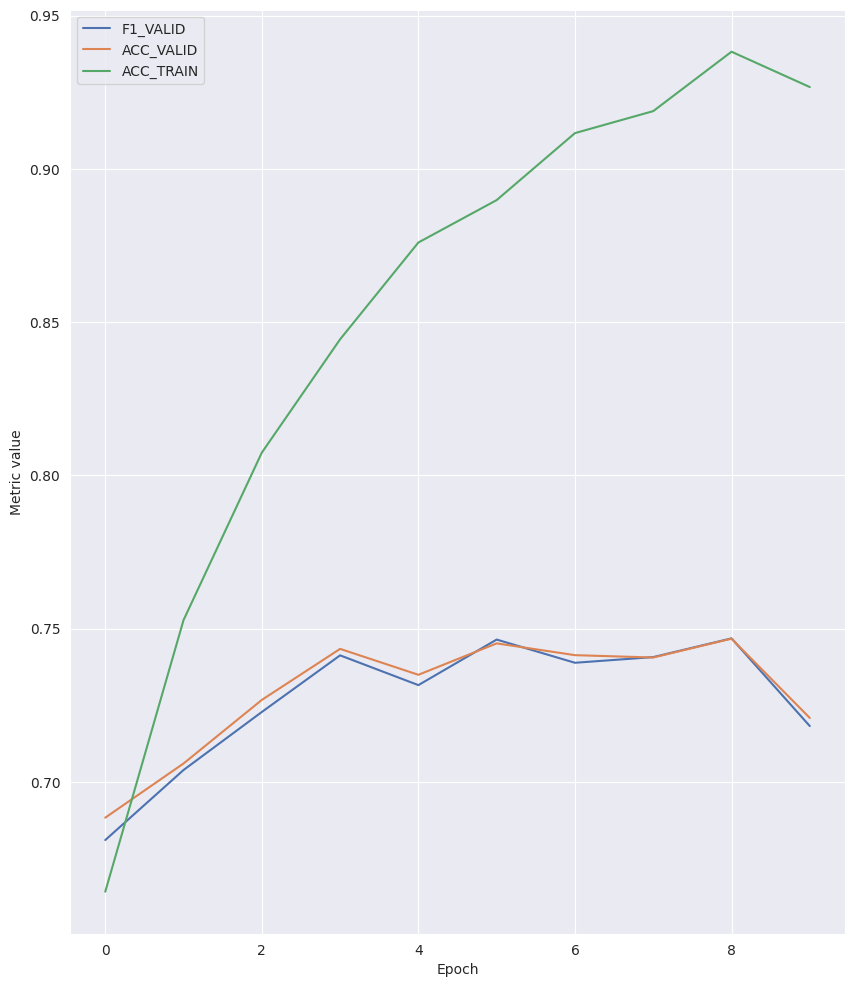

In [63]:
# Plotando as métricas F1 e Acurácia
plt.plot(ckp['valid_f1_history'], label='F1_VALID')
plt.plot(ckp['valid_acc_history'], label='ACC_VALID')
plt.plot(ckp['train_acc_history'], label='ACC_TRAIN')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Metric value')

plt.show()

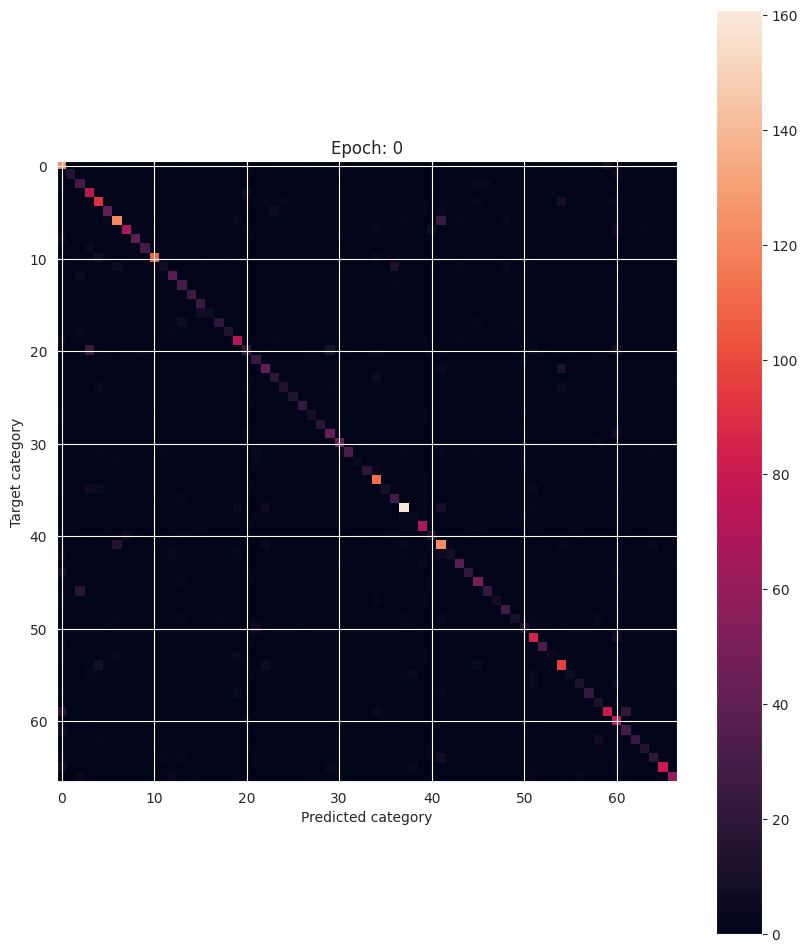

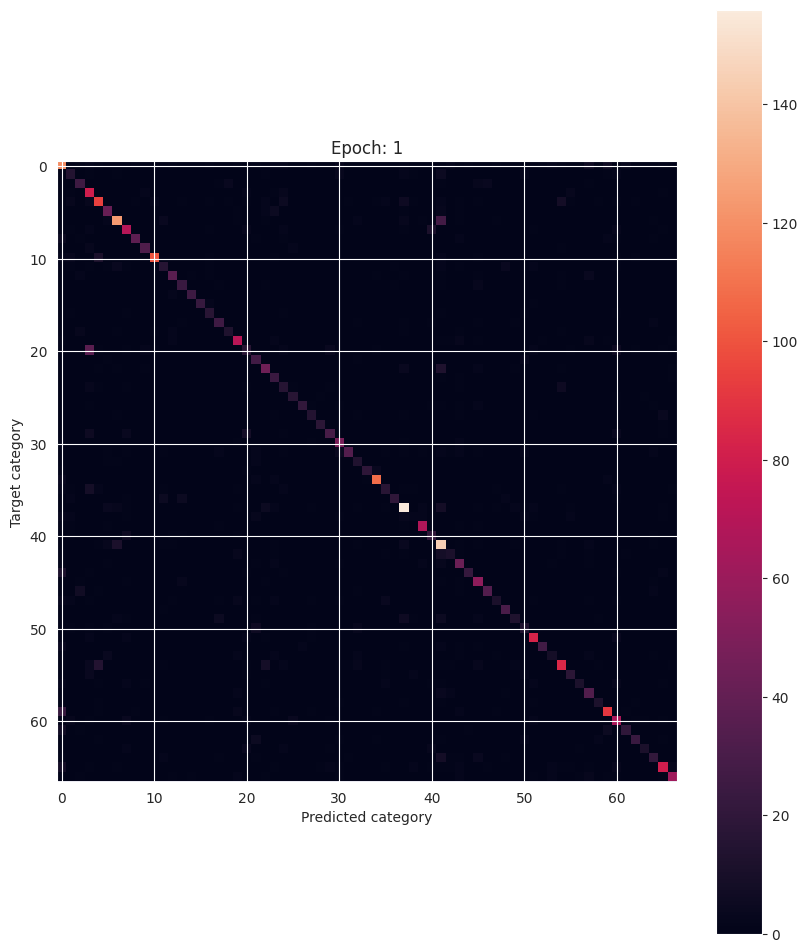

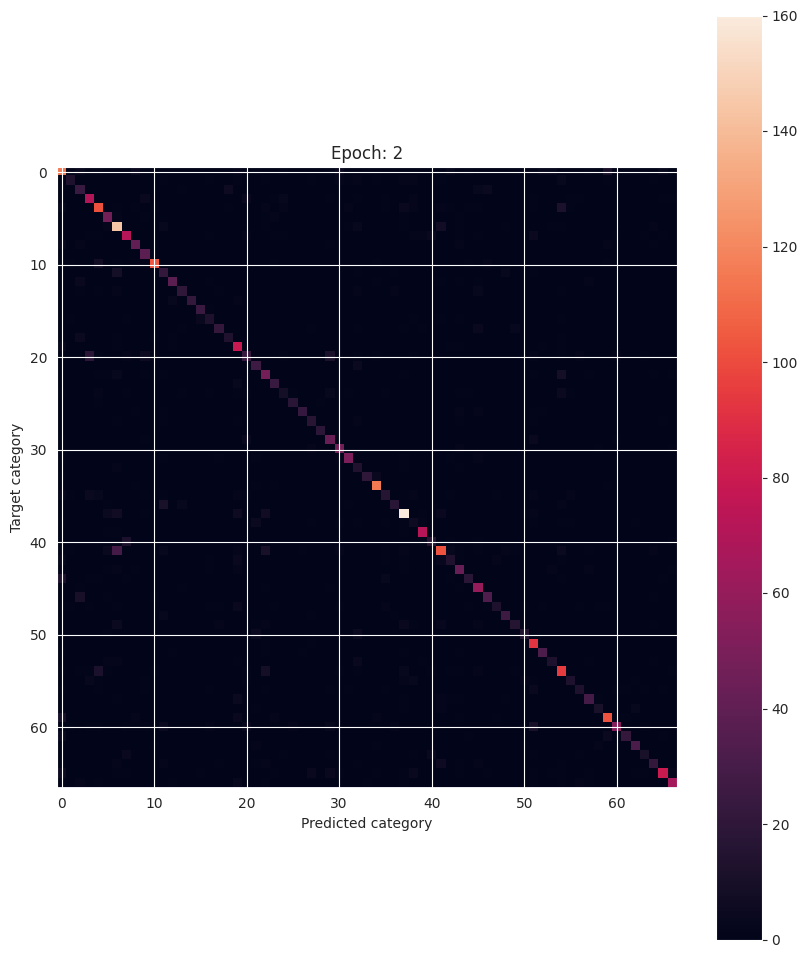

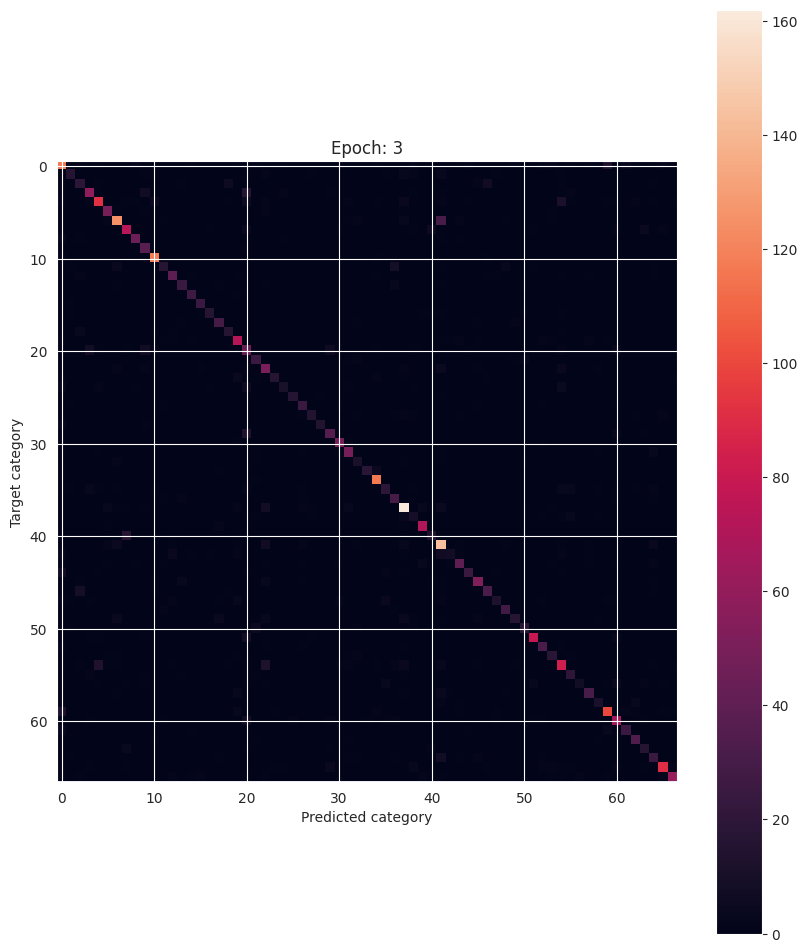

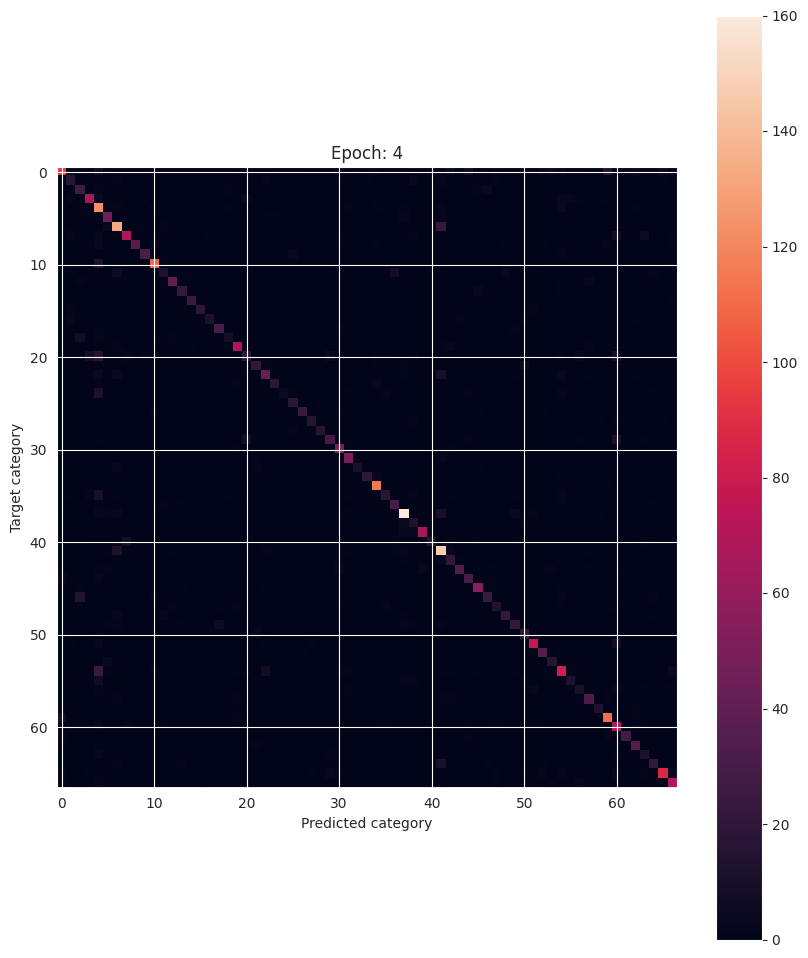

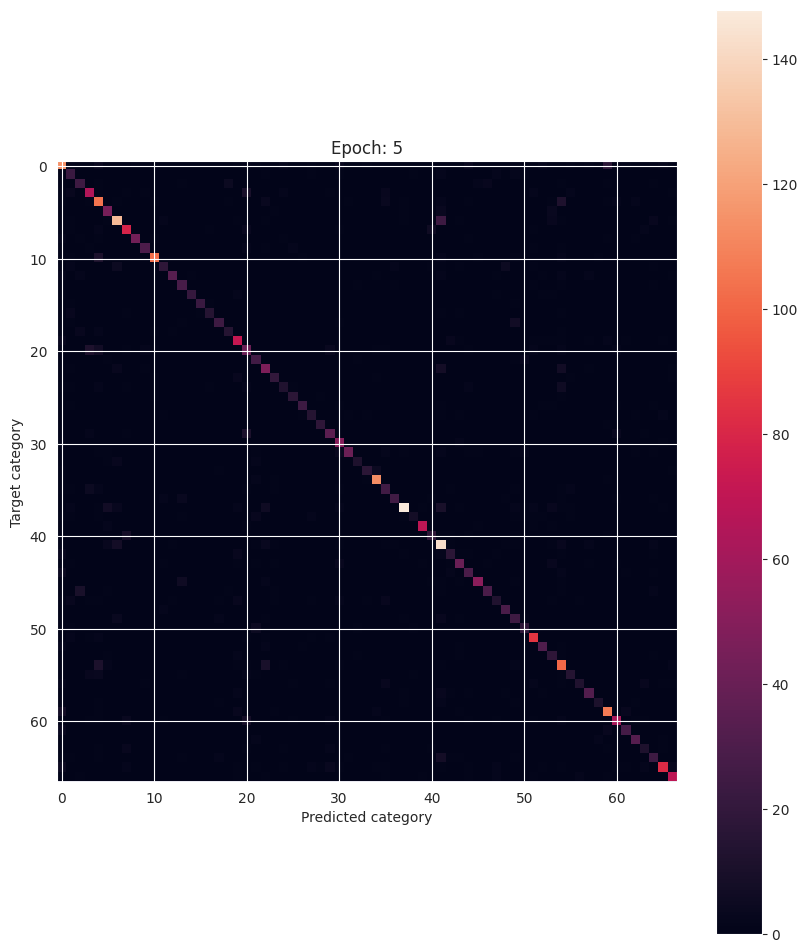

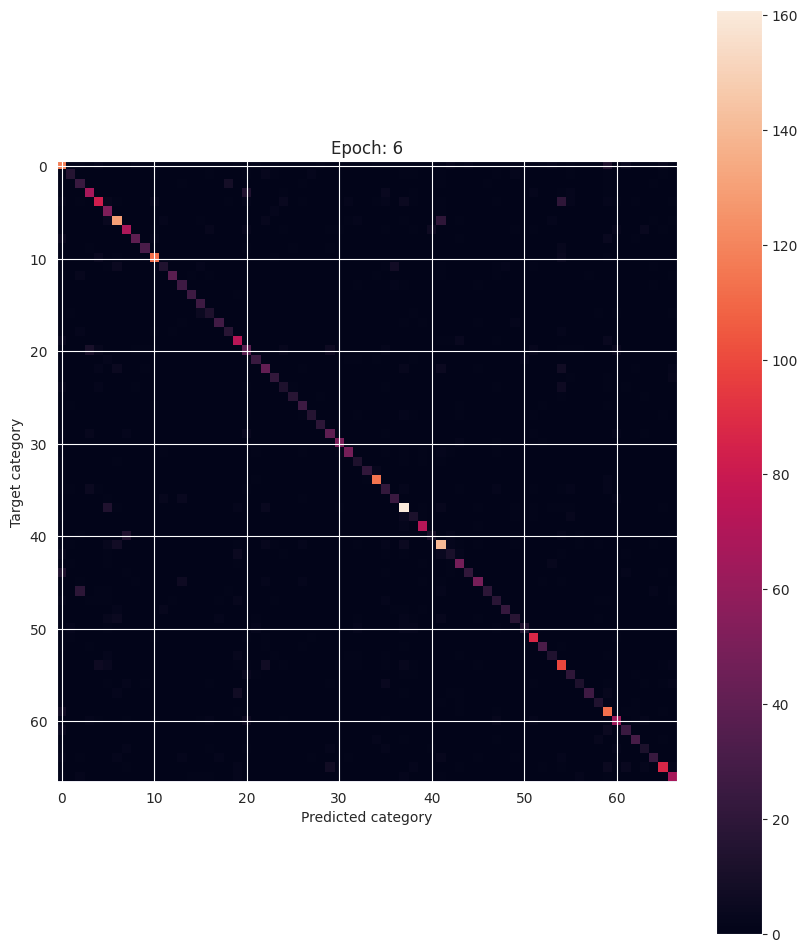

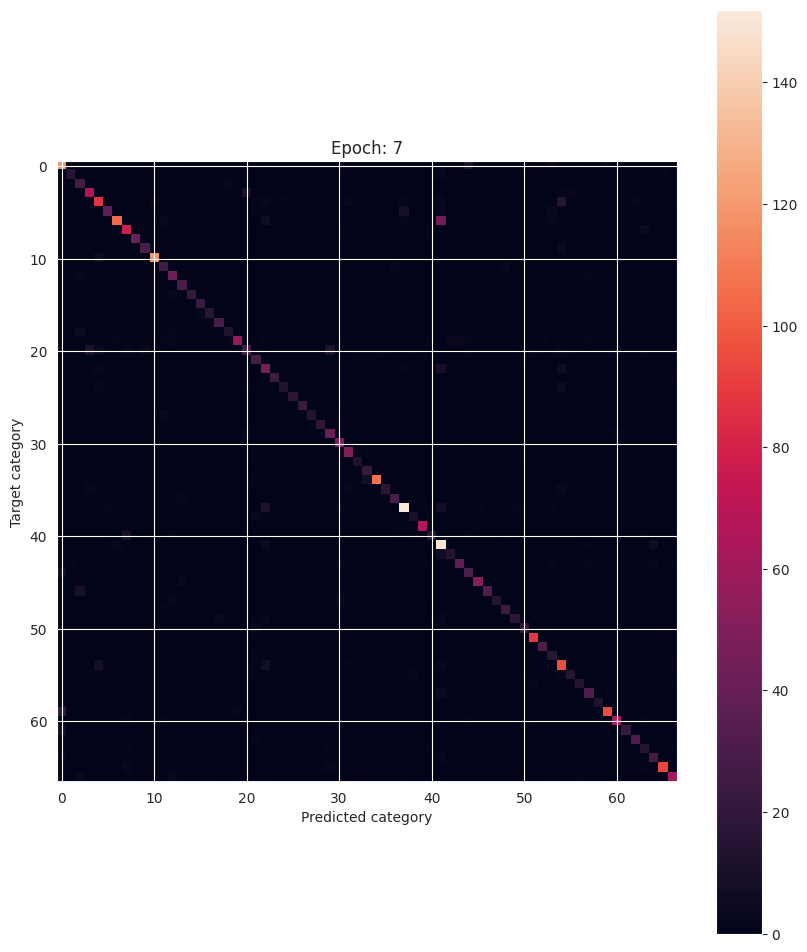

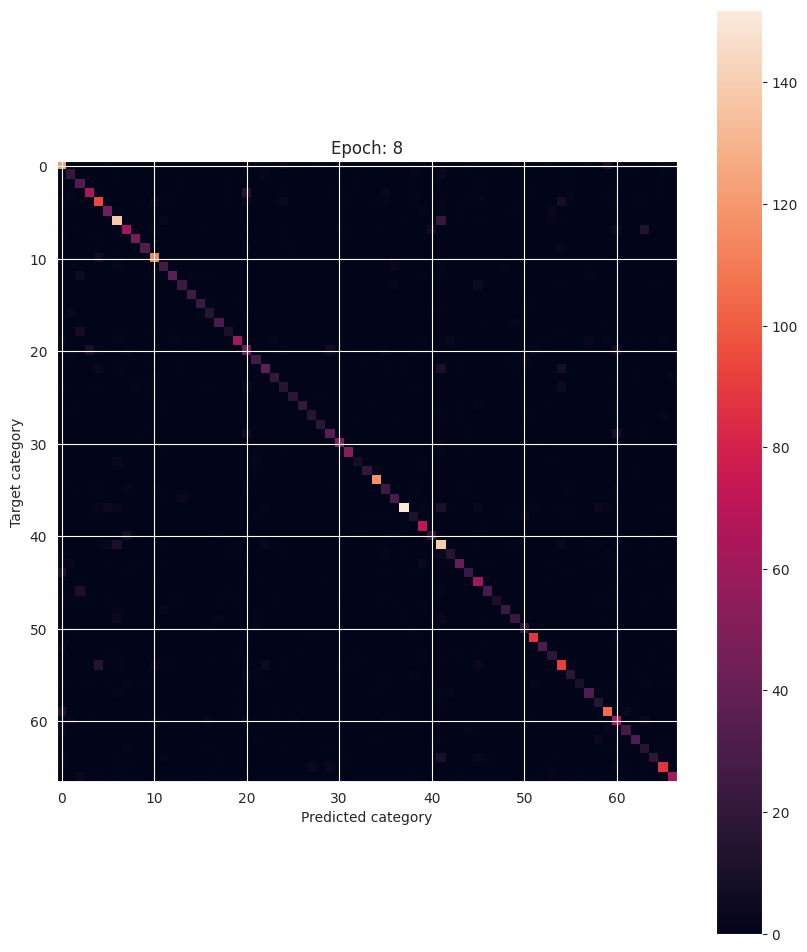

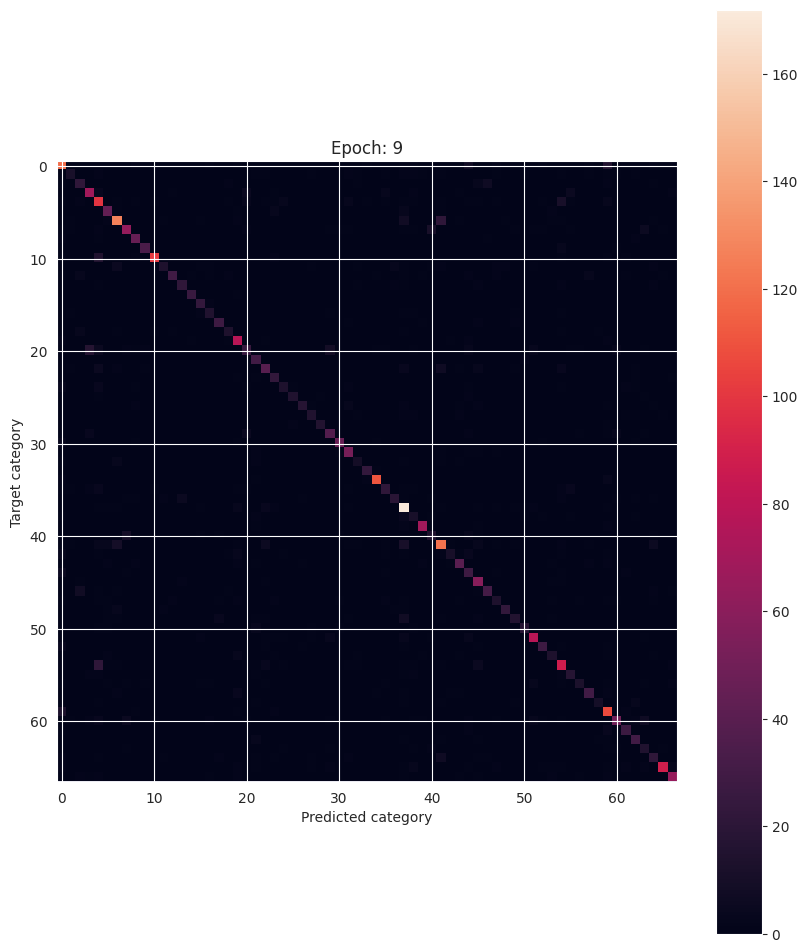

In [64]:
# Plotando a matriz de confusão
for idx in range(len(ckp['valid_cm_history'])):
  plt.imshow(ckp['valid_cm_history'][idx], label='F1')

  plt.ylabel('Target category')
  plt.xlabel('Predicted category')

  plt.colorbar()
  plt.title(f'Epoch: {idx}')
  plt.show()